In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve
# from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
import joblib

In [4]:
df = pd.read_csv("Historical Product Demand.csv")
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [5]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [6]:
df.dropna(inplace=True)

df.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [7]:
df.sort_values(by='Date', ignore_index=True, inplace=True)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,(2)
2,Product_0125,Whse_S,Category_011,2011/10/20,(2)
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,(25)


In [8]:
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [9]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)
# grouping demand and date column
df = df.groupby('Date')['Order_Demand'].sum().reset_index() 
df

,Date,Order_Demand
0,2012/1/1,2
1,2012/1/10,5038288
2,2012/1/11,3321775
3,2012/1/12,2997768
4,2012/1/13,3699049
...,...,...
1355,2015/9/5,0
1356,2015/9/6,850000
1357,2015/9/7,5613784
1358,2015/9/8,4801293


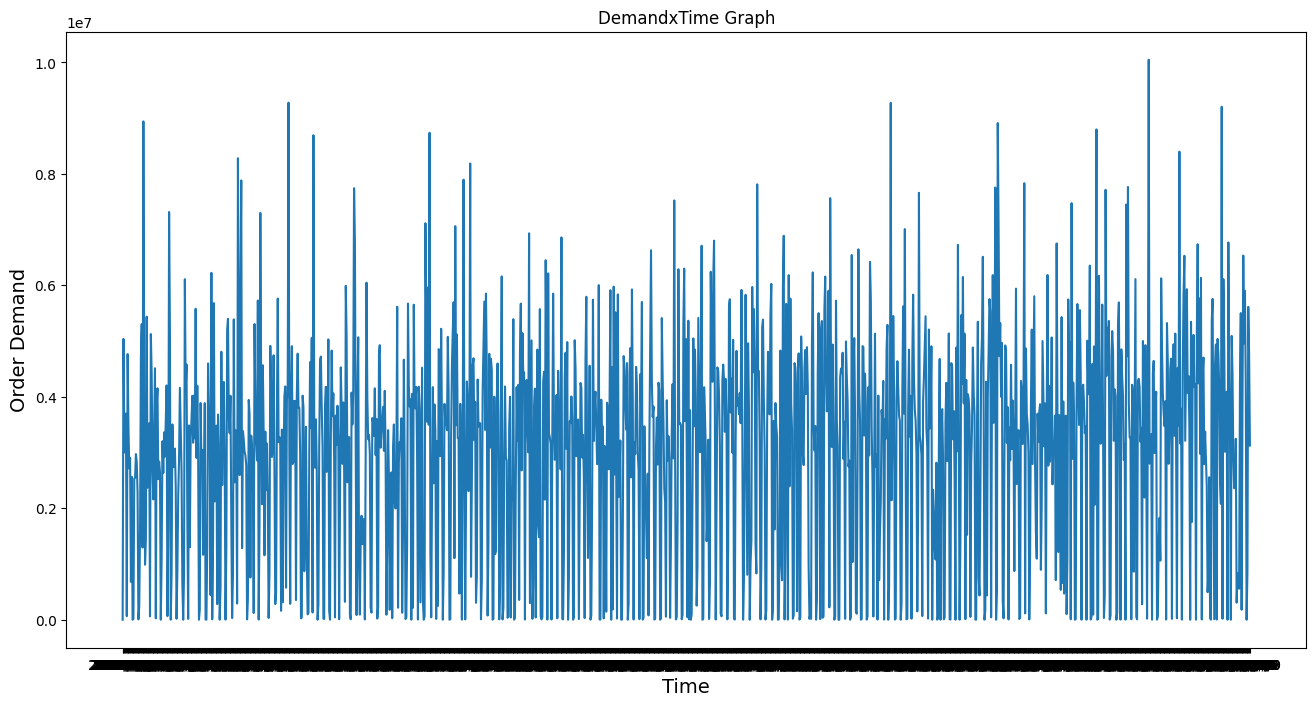

In [10]:
plt.figure(figsize=(16, 8))
plt.title("DemandxTime Graph")
plt.plot(df["Date"], df["Order_Demand"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("Order Demand", fontsize=14)
plt.show()

In [11]:
import math
orderD = df.filter(["Order_Demand"])
# Convert the dataframe to a np array
orderD_array = orderD.values
# See the train data len
train_close_len = math.ceil(len(orderD_array) * 0.8)
train_close_len

1088

In [12]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(orderD_array)
scaled_data

array([[1.99031453e-07],
       [5.01388891e-01],
       [3.30568853e-01],
       ...,
       [5.58659794e-01],
       [4.77804162e-01],
       [3.10985352e-01]])

In [13]:
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(X_train)
        print(y_train)

[array([1.99031453e-07, 5.01388891e-01, 3.30568853e-01, 2.98325061e-01,
       3.68113549e-01, 6.39388544e-03, 4.74326585e-01, 3.44696702e-01,
       2.69870529e-01, 2.89035666e-01, 6.76982600e-02, 2.55127374e-01,
       1.99031453e-05, 1.34953277e-03, 2.51593073e-01, 2.53474816e-01,
       2.95791390e-01, 2.81800375e-01, 2.26411613e-01, 6.16997505e-04,
       2.32949398e-02, 1.63728946e-01, 4.68048834e-01, 5.27871021e-01,
       1.28958549e-01, 8.89847137e-01, 4.36947184e-01, 9.82368500e-02,
       1.43570443e-01, 5.41114873e-01, 2.35637517e-01, 3.14378042e-01,
       3.50701481e-01, 6.01423294e-03, 5.10095025e-01, 4.38815393e-01,
       2.66826044e-01, 2.14868983e-01, 3.41041589e-01, 4.49084321e-01,
       2.49247089e-03, 3.84577530e-01, 4.13256769e-01, 2.50959556e-01,
       2.82362838e-01, 2.63494855e-01, 1.99031453e-05, 1.08951410e-01,
       3.18679211e-01, 2.62004308e-01, 3.34477731e-01, 2.91356671e-01,
       3.52344187e-01, 4.18401035e-01, 6.41219633e-03, 1.62580435e-01,
     

In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1028, 60, 1)

In [16]:
# create the testing dataset
test_data = scaled_data[train_close_len - 60 : , :]
# create X_test and y_test
X_test = []
y_test = df.iloc[train_close_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

In [17]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
model = Sequential([
    LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)),
    LSTM(units=256, activation='relu', return_sequences=False),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1),
    ])

2024-01-21 07:27:20.447276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 07:27:20.448520: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1881345 (7.18 MB)
Trainable params: 1881345 (7.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(optimizer="Adam", loss="mean_squared_error")

In [22]:
model.fit(X_train, y_train,
          epochs=20,
          batch_size=256, 
          verbose=1)

Epoch 1/20


2024-01-21 07:27:56.183603: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2024-01-21 07:27:56.195744: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2024-01-21 07:27:57.028424: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.


1/5 [=====>........................] - ETA: 8s - loss: 0.0579

2024-01-21 07:27:58.370183: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2024-01-21 07:27:58.381996: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.


5/5 [==============================] - 9s 2s/step - loss: 0.0524
Epoch 2/20
5/5 [==============================] - 9s 2s/step - loss: 0.0411
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 0.0427
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 0.0399
Epoch 5/20
5/5 [==============================] - 11s 2s/step - loss: 0.0404
Epoch 6/20
5/5 [==============================] - 11s 2s/step - loss: 0.0402
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 0.0398
Epoch 8/20
5/5 [==============================] - 9s 2s/step - loss: 0.0397
Epoch 9/20
5/5 [==============================] - 9s 2s/step - loss: 0.0397
Epoch 10/20
5/5 [==============================] - 9s 2s/step - loss: 0.0397
Epoch 11/20
5/5 [==============================] - 9s 2s/step - loss: 0.0399
Epoch 12/20
5/5 [==============================] - 9s 2s/step - loss: 0.0406
Epoch 13/20
5/5 [==============================] - 9s 2s/step - loss: 0.0401
Epoch 14/20
5/5

In [33]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

9/9 [==============================] - 1s 86ms/step


C:\Users\karan\AppData\Local\Temp\ipykernel_28448\2542379320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


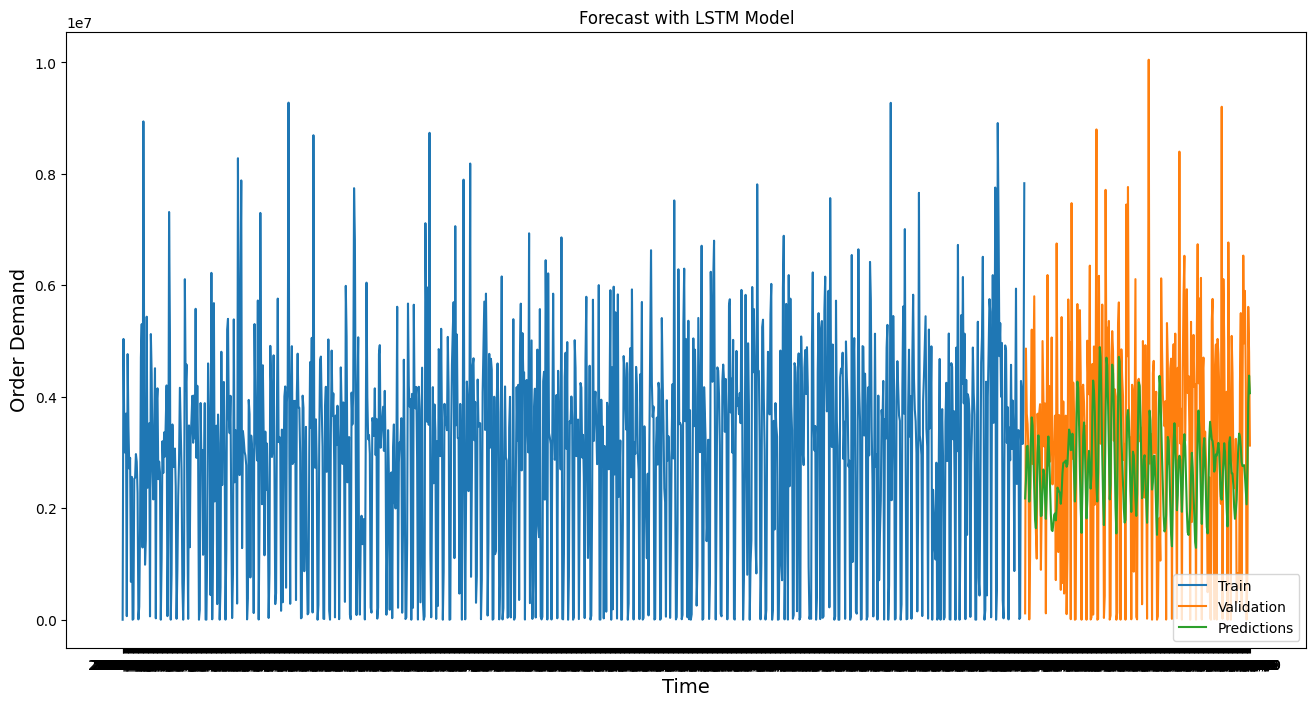

In [37]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["Order_Demand"])
plt.plot(df["Date"][train_close_len:], valid[["Order_Demand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

In [61]:
joblib.dump(model, 'Demand.joblib')

['Demand.joblib']